In [58]:
import pandas as pd
import numpy as np
import random
import torch
import cv2
from pathlib import Path
from tqdm import tqdm

from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import os
from collections import Counter
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

In [59]:
# giả sử bạn đã tạo file CSV labels.csv với cột [filename, label]
df = pd.read_csv("data/flickr30k_images/results.csv", sep='\t')
img_dir = Path("data/flickr30k_images/flickr30k_images")
print("Số dòng:", len(df))
print(df.info())
print(df.head())

Số dòng: 158915
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158915 entries, 0 to 158914
Data columns (total 1 columns):
 #   Column                               Non-Null Count   Dtype 
---  ------                               --------------   ----- 
 0   image_name| comment_number| comment  158915 non-null  object
dtypes: object(1)
memory usage: 1.2+ MB
None
                 image_name| comment_number| comment
0  1000092795.jpg| 0| Two young guys with shaggy ...
1  1000092795.jpg| 1| Two young , White males are...
2  1000092795.jpg| 2| Two men in green shirts are...
3  1000092795.jpg| 3| A man in a blue shirt stand...
4  1000092795.jpg| 4| Two friends enjoy time spen...


In [60]:
def is_blurry(image, threshold=100.0):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fm = cv2.Laplacian(gray, cv2.CV_64F).var()
    return fm < threshold


In [61]:
def brightness_level(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return np.mean(gray)

def is_bad_brightness(image, low=40, high=220):
    b = brightness_level(image)
    return b < low or b > high


In [62]:
def preprocess_image(image_path, size=(224, 224)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize
    img_resized = cv2.resize(img, size)

    # Normalize
    img_norm = img_resized.astype("float32") / 255.0

    return img, img_resized, img_norm


Total number of images: 31783


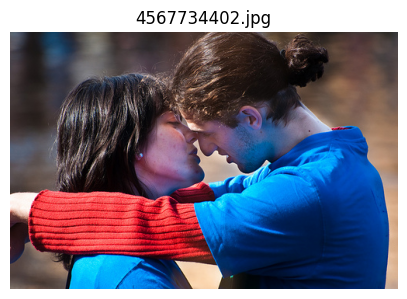

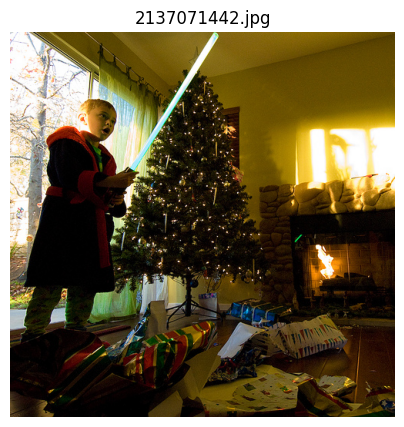

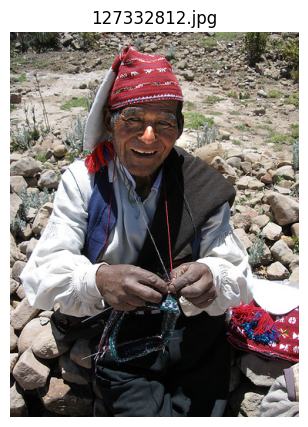

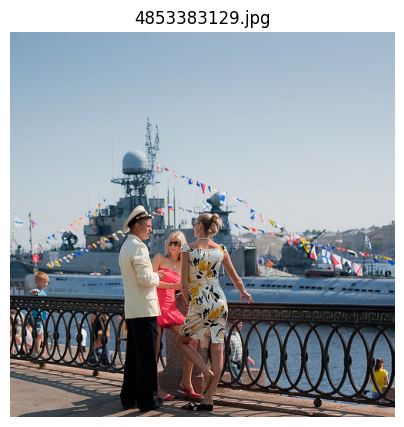

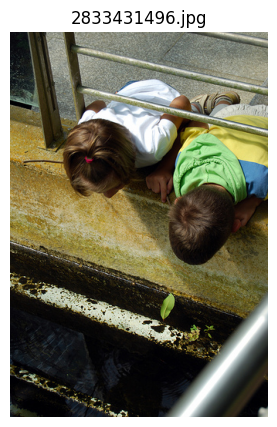

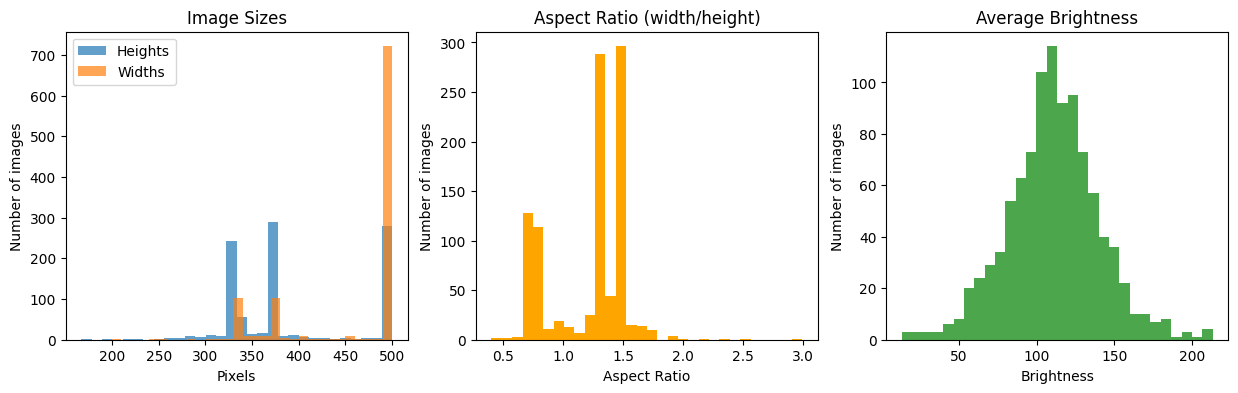

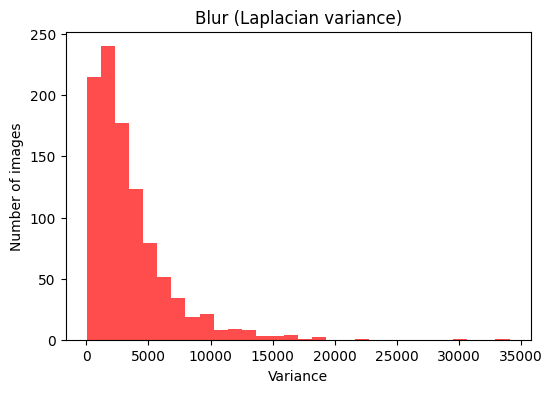

Checked images: 1000
Average brightness: 110.87
Average blur: 3476.93
Average size: 394.7 x 461.8


In [63]:
# ---- CONFIG ----
DATA_DIR = "data/flickr30k_images/flickr30k_images"   # folder containing all images
IMG_SIZE = (256, 256)  # desired resize size (not used yet)
SAMPLE_COUNT = 5       # number of sample images to display
MAX_CHECK = 1000       # number of images to check statistics (avoid MemoryError)

# -----------------------------
# LOAD IMAGE PATHS
# -----------------------------
image_paths = [os.path.join(DATA_DIR, f)
               for f in os.listdir(DATA_DIR)
               if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

print("Total number of images:", len(image_paths))

# -----------------------------
# Functions
# -----------------------------
def brightness_level(img):
    """Compute average brightness of an image."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return np.mean(gray)

def blur_variance(img):
    """Compute blur measure using Laplacian variance."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

# -----------------------------
# 1. Display sample images
# -----------------------------
sample_paths = random.sample(image_paths, min(SAMPLE_COUNT, len(image_paths)))

for path in sample_paths:
    img = cv2.imread(path)
    if img is None:
        continue
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(5,5))
    plt.imshow(img_rgb)
    plt.title(os.path.basename(path))
    plt.axis("off")
    plt.show()

# -----------------------------
# 2-5. Collect statistics: size, aspect ratio, brightness, blur
# -----------------------------
heights, widths, ratios, brightnesses, blurs = [], [], [], [], []
check_paths = image_paths[:MAX_CHECK]  # limit to avoid MemoryError

for path in tqdm(check_paths, desc="Collecting image statistics"):
    img = cv2.imread(path)
    if img is None:
        continue

    h, w = img.shape[:2]
    heights.append(h)
    widths.append(w)
    ratios.append(w/h)
    brightnesses.append(brightness_level(img))
    blurs.append(blur_variance(img))

# -----------------------------
# Plot histograms
# -----------------------------
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.hist(heights, bins=30, alpha=0.7, label="Heights")
plt.hist(widths, bins=30, alpha=0.7, label="Widths")
plt.title("Image Sizes")
plt.xlabel("Pixels")
plt.ylabel("Number of images")
plt.legend()

plt.subplot(1,3,2)
plt.hist(ratios, bins=30, color='orange')
plt.title("Aspect Ratio (width/height)")
plt.xlabel("Aspect Ratio")
plt.ylabel("Number of images")

plt.subplot(1,3,3)
plt.hist(brightnesses, bins=30, color='green', alpha=0.7)
plt.title("Average Brightness")
plt.xlabel("Brightness")
plt.ylabel("Number of images")

plt.show()

# -----------------------------
# Blur histogram
# -----------------------------
plt.figure(figsize=(6,4))
plt.hist(blurs, bins=30, color='red', alpha=0.7)
plt.title("Blur (Laplacian variance)")
plt.xlabel("Variance")
plt.ylabel("Number of images")
plt.show()

# -----------------------------
# Basic statistics
# -----------------------------
print(f"Checked images: {len(heights)}")
print(f"Average brightness: {np.mean(brightnesses):.2f}")
print(f"Average blur: {np.mean(blurs):.2f}")
print(f"Average size: {np.mean(heights):.1f} x {np.mean(widths):.1f}")


In [64]:
clean_images = []
bad_blur = []
bad_brightness = []
bad_read = []     # images that cannot be read (important!)

for path in image_paths:
    img = cv2.imread(path)

    # 1) Check if the image failed to load
    if img is None:
        bad_read.append(path)
        continue

    # 2) Check for blurry images
    if is_blurry(img):
        bad_blur.append(path)
        continue

    # 3) Check for abnormal brightness (too dark or too bright)
    if is_bad_brightness(img):
        bad_brightness.append(path)
        continue

    # 4) Good images
    clean_images.append(path)

# ----------------------
# Print results
# ----------------------
print("Total number of images:", len(image_paths))
print("Good images:", len(clean_images))
print("Blurry images:", len(bad_blur))
print("Images with abnormal brightness:", len(bad_brightness))
print("Unreadable images:", len(bad_read))


Total number of images: 31783
Good images: 31074
Blurry images: 55
Images with abnormal brightness: 654
Unreadable images: 0
